# Installing pyspark requirements

In [2]:
import os
os.environ["JAVA_HOME"] = "/lib/jvm/java-11-openjdk-amd64"
# Because otherwise custom modules import errors
import sys
sys.path.append('../')
os.makedirs("../figures_report/rank_stability", exist_ok=True)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import plotly.graph_objs as go
import plotly.express as px

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [4]:
import pyspark

In [5]:
from wikipedia_core_events_semantic.ranking_helpers import *
from wikipedia_core_events_semantic.rank_turbulence_divergence import *
from wikipedia_core_events_semantic.pages_groups_extraction import*

## Initialize context 

In [6]:
conf = pyspark.SparkConf().setMaster("local[3]").setAll([
                                   ('spark.driver.memory','100G'),
                                   ('spark.executor.memory', '100G'),
                                   ('spark.driver.maxResultSize', '0'),
                                    ('spark.executor.cores', '3'),
                                    ('spark.local.dir', '/scratch/descourt/spark')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
# create the context
sc = spark.sparkContext
sc.setLogLevel('ERROR')

23/06/19 12:35:20 WARN Utils: Your hostname, iccluster060 resolves to a loopback address: 127.0.1.1; using 10.90.39.11 instead (on interface ens786f0)
23/06/19 12:35:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/19 12:35:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/19 12:35:24 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/06/19 12:35:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/19 12:35:27 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# PLotting functions

In [55]:
def plot_salient(df, group='date', path=None):
    fig = go.Figure()
    
    l = []
    for n, grp in df.groupby(group):
        d1_grp = grp[grp['div_sign'] < 0]
        d2_grp = grp[grp['div_sign'] > 0]
        fig.add_trace(
            go.Bar(
                x=d1_grp['div'],
                y=d1_grp['page'],
                name=d1_grp['month'].unique()[0],
                orientation='h',
                text = d1_grp['ranks'],
                textposition = "outside",
                marker={'color': 'red'},
            hovertemplate="Divergence %{x} <br>Ranks %{text}"))
        fig.add_trace(
            go.Bar(
                x=d2_grp['div'],
                y=d2_grp['page'],
                name=d2_grp['month'].unique()[0],
                orientation='h',
                text = d2_grp['ranks'],
                textposition = "outside",
             marker={'color': 'green'},
            hovertemplate="Divergence %{x} <br>Ranks %{text}"))
        l.append(n)

    # Create and add slider
    steps = []
    for i in np.arange(0, len(fig.data), 2):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"Slider switched to {group}: " + str(l[i//2])}],
            label=str(l[i//2])# layout attribute
        )
        step["args"][0]["visible"][i] = True
        step["args"][0]["visible"][i+1] = True # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": f"{group}: "},
        pad={"t": 50},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
        showlegend=True,
        autosize=False,
        height=800,
        width=1000,
        xaxis_title='Individual divergence contribution',
        yaxis_title='Page',
        legend_title='Dates to compare'
                    )
    
    fig.show()
    
    if path is not None:
        fig.write_html(path)
    
    


In [63]:
def plot_salient_print(df, group, group_item, path=None):

    grp = df.loc[df[group] == group_item]
    d1_grp = grp[grp['div_sign'] < 0]
    d2_grp = grp[grp['div_sign'] > 0]
    
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=d1_grp['div'],
            y=d1_grp['page'],
            name=d1_grp['month'].unique(),
            orientation='h',
            text = d1_grp['ranks'],
            textposition = "outside",
            marker={'color': 'red'},
        hovertemplate="Divergence %{x} <br>Ranks %{text}"))
    fig.add_trace(
        go.Bar(
            x=d2_grp['div'],
            y=d2_grp['page'],
            name=d2_grp['month'].unique(),
            orientation='h',
            text = d2_grp['ranks'],
            textposition = "outside",
         marker={'color': 'green'},
        hovertemplate="Divergence %{x} <br>Ranks %{text}"))
    
    fig.update_layout(
    height=800,
    width=1000,
    legend_title='Dates to compare',
    xaxis_title=dict(text='Individual divergence contribution', font=dict(size=20)),
    yaxis_title=dict(text='Page', font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=10)),
    xaxis = dict( tickfont = dict(size=20)))
    
    fig.show()
        
    if path is not None:
        fig.write_image(path)

In [ ]:
def plot_salient_print(df, group, group_item, path=None):
    
    grp = df.loc[df[group] == group_item]
    d1_grp = grp[grp['div_sign'] < 0]
    d2_grp = grp[grp['div_sign'] > 0]
    
    fig = px.bar(grp, x='div', y='page', color='topic', pattern_shape='div_sign', orientation='h', text='ranks', textposition = "outside")
    fig.show()

# Data

## Download data

df_divs was computed with the following command `python make_and_plot.py --mode rtd --alpha 0.3 --memory 120`

In [7]:
dfs = spark.read.parquet("/scratch/descourt/processed_data/en/pageviews_en_2015-2023.parquet").withColumn('project', lit('en'))

In [8]:
df_divs = spark.read.parquet('/scratch/descourt/plots/thesis/RTD_all.parquet')

In [9]:
# Topics
df_topics_sp = spark.read.parquet('/scratch/descourt/metadata/topics/topic_en/topics-enwiki-20230320-parsed.parquet')

In [71]:
dfs_change = spark.read.parquet("/scratch/descourt/processed_data/en/pageviews_en_articles_ev_2023-03.parquet")

## Process data

In [10]:
df_high_volume = extract_volume(dfs, high=True).cache()

In [11]:
df_low_volume = extract_volume(dfs, high=False).cache()

In [12]:
df_divs_augm = df_divs.join(df_topics_sp.select('page_id', col('topics_specific_unique').alias('topic')).distinct(), 'page_id').cache()

In [13]:
df_high_volume_augm = df_high_volume.join(df_topics_sp.select('page_id', col('topics_specific_unique').alias('topic')).distinct(), 'page_id').cache()

In [14]:
df_low_volume_augm = df_low_volume.join(df_topics_sp.select('page_id', col('topics_specific_unique').alias('topic')).distinct(), 'page_id').cache()

In [15]:
dfs_top = dfs.join(df_topics_sp.select('page_id', col('topics_specific_unique').alias('topic')).distinct(), 'page_id').cache()

## Estimate the loss when matching with topics

In [249]:
df_low_volume.count()

475441301

In [250]:
df_low_volume_augm.count()

454331707

In [252]:
454331707 / 475441301 * 100

95.55999995044604

In [254]:
df_high_volume.count()

61972033

In [255]:
df_high_volume_augm.count()

60246933

In [256]:
60246933/ 61972033 * 100

97.2163249832388

# Stable and unstable pages

## For Dec 2020 - Jan 2021

Play with $\alpha$ parameter. $\alpha \to 0$ and $\alpha \to \infty$

In [102]:
from wikipedia_core_events_semantic.make_and_plot import set_up_mapping
color_map = set_up_mapping(grouped=False)

In [193]:
df_plot_raw = pd.read_csv("/scratch/descourt/plots/thesis/divs_alphas.csv.gzip", compression='gzip')

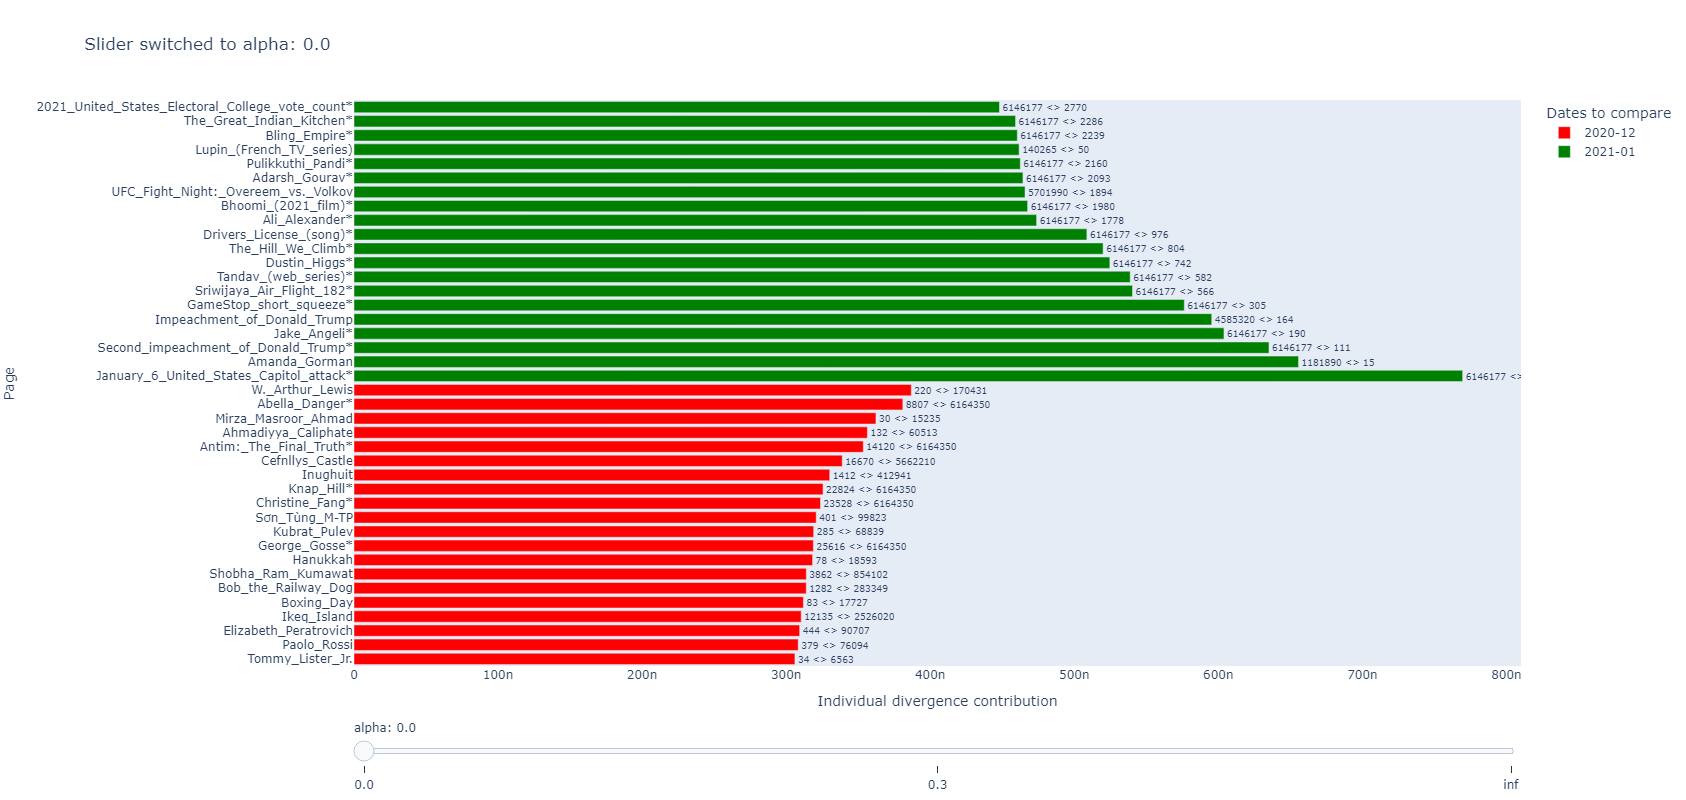

In [69]:
plot_salient(df_plot_raw, group='alpha')

In [194]:
df_plot = spark.createDataFrame(df_plot_raw)\
                .join(dfs_change.select(col('last_name').alias('page'), col('last_page_id').alias('page_id')).distinct(), on='page')\
                .join(df_topics_sp.select('page_id', col('topics_specific_unique').alias('topic')).distinct(), on='page_id').toPandas()

/home/descourt/.conda/envs/wiki_sem/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/descourt/.conda/envs/wiki_sem/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



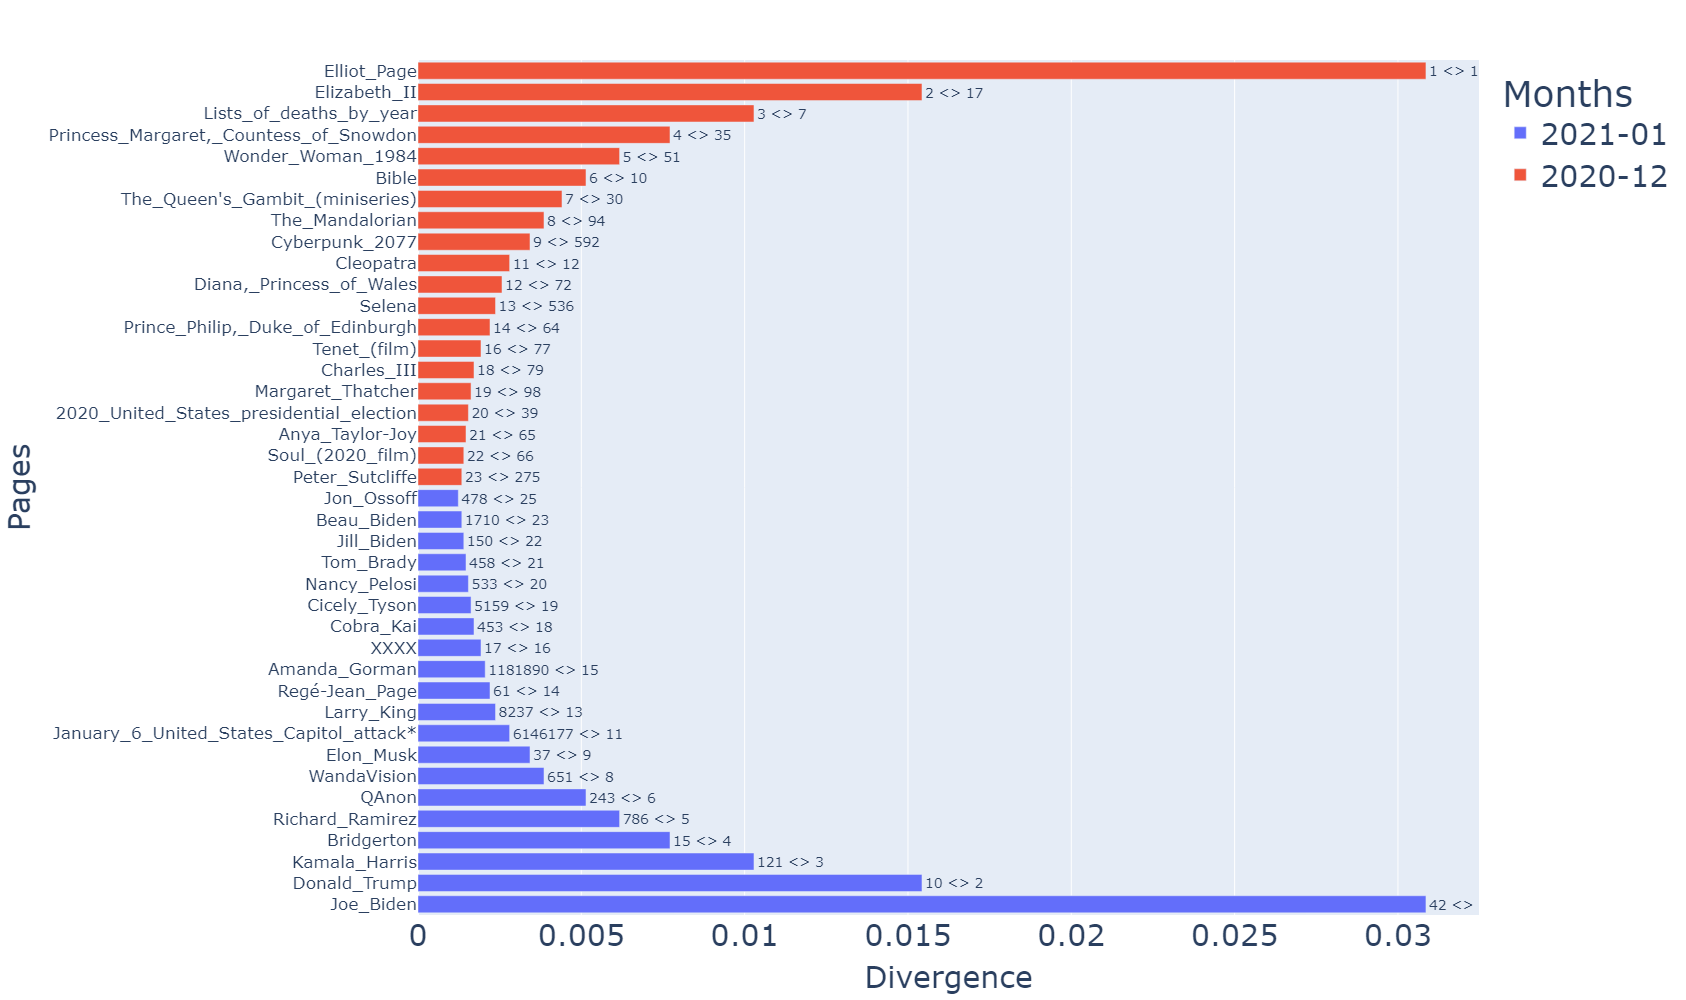

In [239]:
# TODO uncomment the lines below to plot with matched topics

grp = df_plot_raw.loc[df_plot_raw['alpha'] == np.inf]
# grp = df_plot.loc[df_plot['alpha'] == np.inf]
#fig = px.bar(grp.sort_values('topic'), x='div', y='page', color='topic', pattern_shape='month', orientation='h', text='ranks', color_discrete_map = color_map)
fig = px.bar(grp, x='div', y='page', color='month', orientation='h', text='ranks')
fig.update_traces(textposition='outside', textfont=dict(size=17))
fig.update_layout(height=1000,
                  width=2500,
                  xaxis_title=dict(text='Divergence', font=dict(size=30)),
                  yaxis_title=dict(text='Pages', font=dict(size=30)),
                  legend=dict(title='Months', font=dict(size=30)),
                yaxis = dict( tickfont = dict(size=17)),
                xaxis = dict( tickfont = dict(size=30)),)
fig.update_annotations(font_size=15)
fig.show()
fig.write_image("figures_report/rank_stability/alpha_infnotopic.pdf")

## Throughout the time 

$\alpha = 0.3$

In [177]:
from pandas.tseries.offsets import DateOffset
def prepare_divs_plot(df_divs_augm):

    # Sample and take max ranks
    w = Window.partitionBy('date').orderBy(desc('div'))
    df_div_pd = df_divs_augm.withColumn('divr', row_number().over(w)).where(col('divr') < 100).drop('divr').toPandas()
    max_rk_1 = df_divs_augm.select(max('rank_1').alias('m_1')).collect()[0]['m_1']
    max_rk_2 = df_divs_augm.select(max('rank_2').alias('m_2')).collect()[0]['m_2']

    # For labelling
    df_div_pd['ranks'] = df_div_pd.apply(lambda r: f"{int(r['rank_1'])} <> {int(r['rank_2'])}", axis=1)
    # Note the exclusive types with an asterix
    df_div_pd['page'] = df_div_pd.apply(
        lambda r: r.page + str('*') if ((r['rank_1'] == max_rk_1) | (r['rank_2'] == max_rk_2)) else r.page, axis=1)

    # Take the top divergence for both dates
    df_div_pd['div_sign'] = df_div_pd.apply(lambda r: (2 * int(r['rank_2'] < r['rank_1']) - 1) * r[f'div'], axis=1)
    df_plot_head = df_div_pd.sort_values(by=f'div_sign', ascending=False).groupby('date')[
        ['div', 'div_sign', 'page', 'ranks', 'topic', 'date']] \
        .head(20).reset_index()
    df_plot_tail = df_div_pd.sort_values(by=f'div_sign', ascending=False).groupby('date')[
        ['div', 'div_sign', 'page', 'ranks', 'topic', 'date']] \
        .tail(20).reset_index()
    df_plot = pd.concat([df_plot_head, df_plot_tail])

    # labels
    df_plot['month'] = df_plot.apply(lambda r: (pd.to_datetime(r['date'] + '-01') - DateOffset(months=1)).date() if r['div_sign'] < 0 else r['date'] + '-01', axis=1)
    return df_plot

In [225]:
df_plot_date = prepare_divs_plot(df_divs_augm)

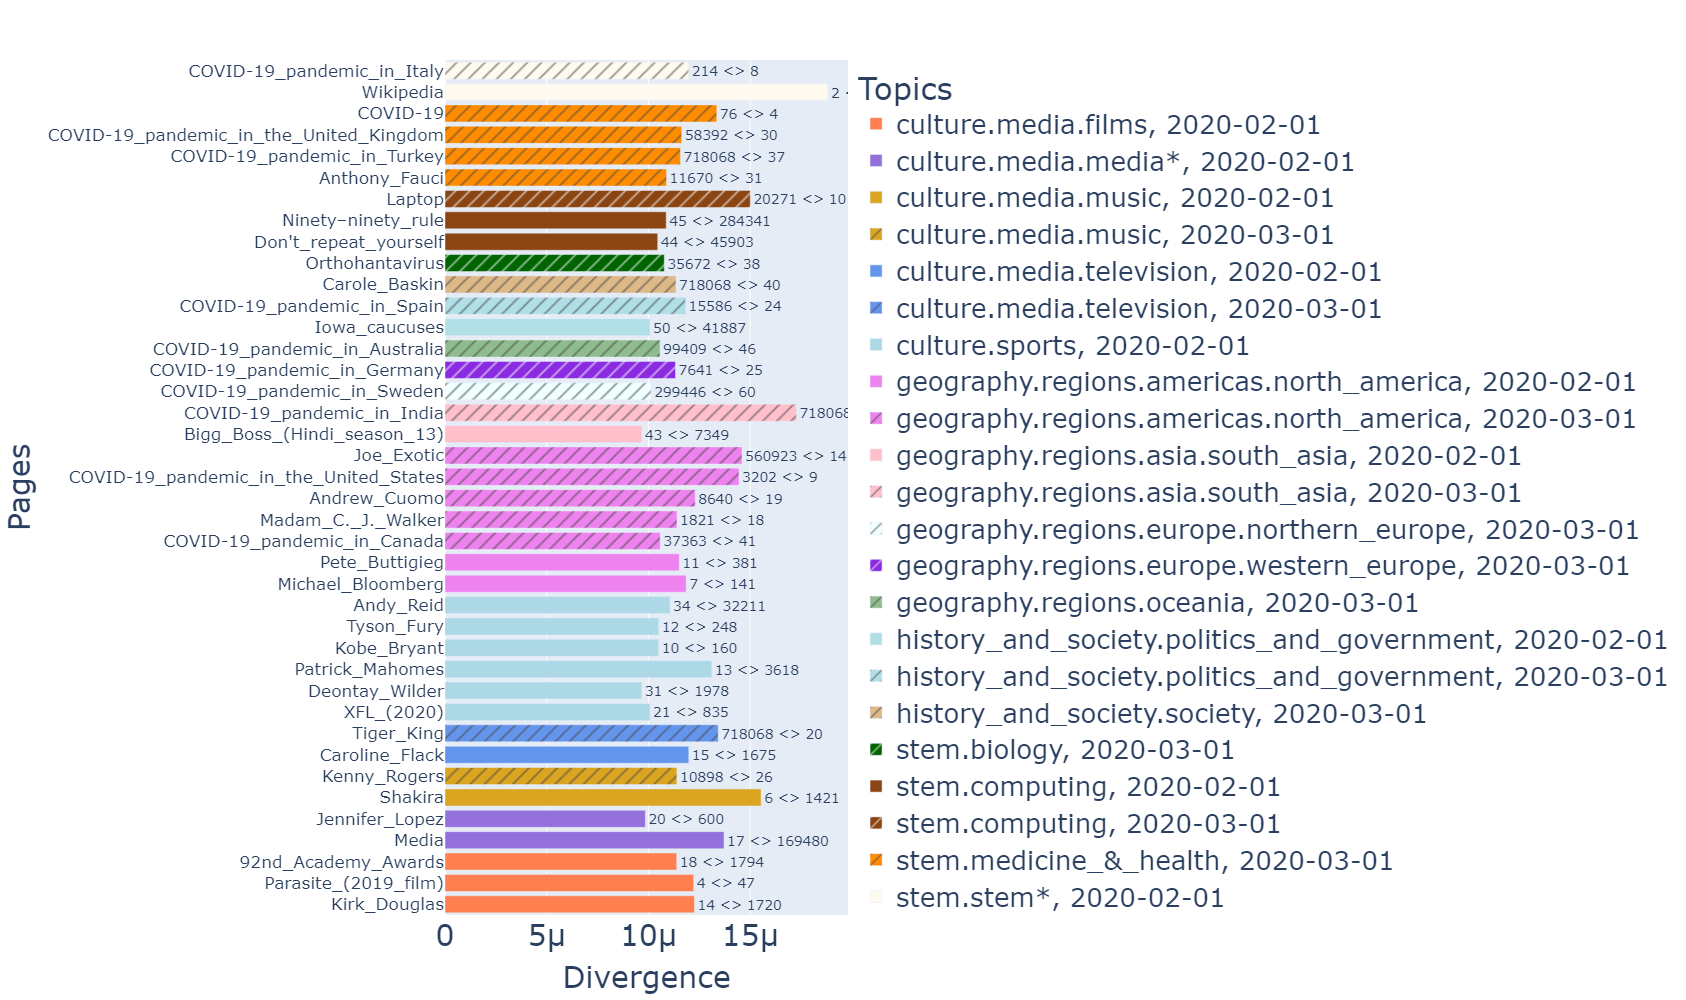

In [257]:
grp = df_plot_date.loc[df_plot_date['date'] == '2020-03']
fig = px.bar(grp.sort_values('topic'), x='div', y='page', color='topic', pattern_shape='month', orientation='h', text='ranks', color_discrete_map = color_map)
#fig = px.bar(grp, x='div', y='page', color='month', orientation='h', text='ranks')
fig.update_traces(textposition='outside', textfont=dict(size=17))
fig.update_layout(height=1000,
                  width=2500,
                  xaxis_title=dict(text='Divergence', font=dict(size=30)),
                  yaxis_title=dict(text='Pages', font=dict(size=30)),
                  legend=dict(title='Topics', font=dict(size=26)),
                yaxis = dict( tickfont = dict(size=17)),
                xaxis = dict( tickfont = dict(size=30)),)
fig.update_annotations(font_size=15)
fig.show()
fig.write_image("figures_report/rank_stability/date_covid.pdf")

## Core stability across time

Plot core divergence score across time. 

In [200]:
df_core_stab = df_divs.groupBy('date').agg(sum('div').alias('div_sum')).toPandas()

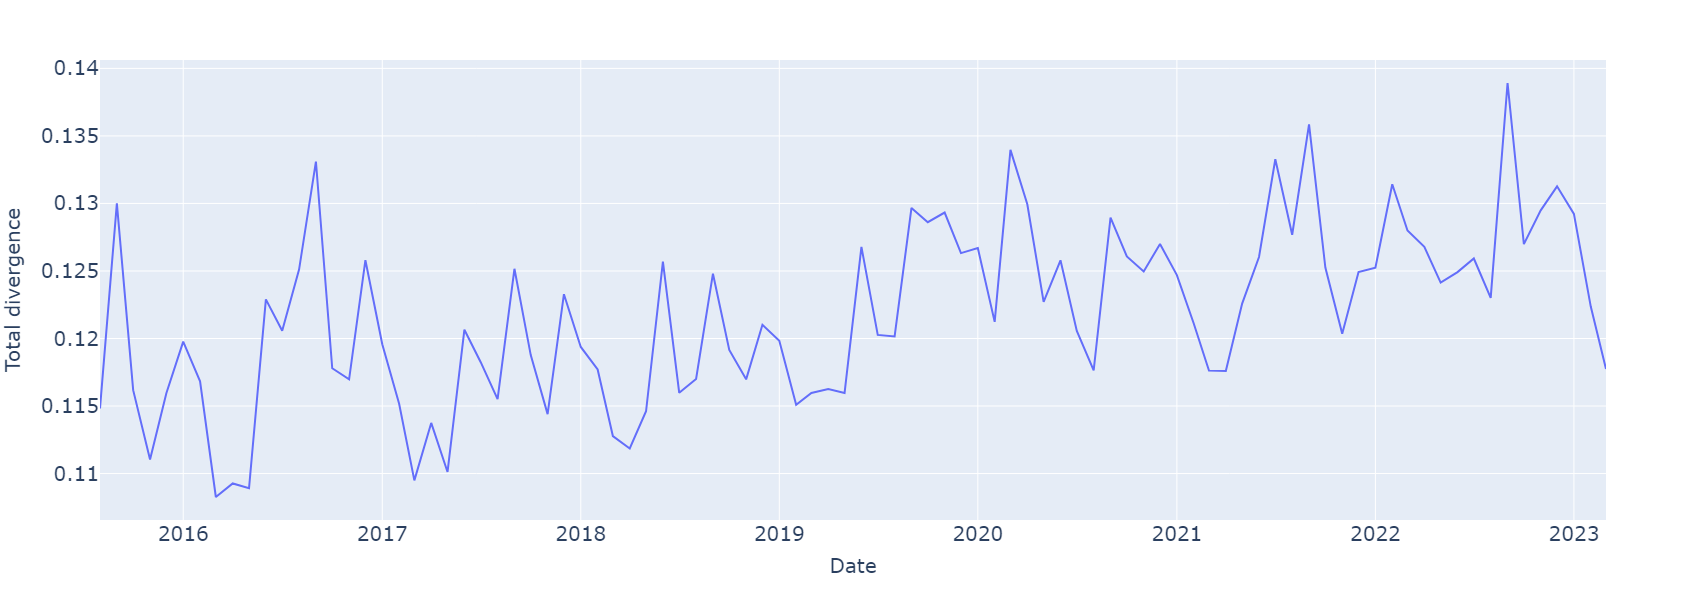

In [208]:
fig = px.line(df_core_stab.sort_values('date'), x='date', y='div_sum')
fig.update_layout(width = 1000,
    xaxis_title=dict(text='Date', font=dict(size=20)),
    yaxis_title=dict(text='Total divergence', font=dict(size=20)),
    yaxis = dict( tickfont = dict(size=20)),
    xaxis = dict( tickfont = dict(size=20)),
    height=600)
fig.show()
fig.write_image("figures_report/rank_stability/core_div_ev.pdf")